In [1]:
import os 
 
os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Initialisation de constantes
batch_size = 16 # taille de l'échantillon dont les erreurs de prédiction servent à maj les paramètres
latent_dim = 32 # trop faible = compression extrême rendant illisible l'image
                # trop élevé = reconstruction fidèle mais s'écarte de l'objectif de compression lié à l'usage d'un VAE
kl_weight = 0.5 # trop faible = reconstruction impeccable des données mais aucun pouvoir d'échantillonnage
                # trop élevé = reconstruction bruitée
num_classes = 10 # vérifier le nombre de classes dans les données (par défaut 10)
dim_params = 784 # vérifier les dimensions de vos images (H*W)
seed = 0xffff

In [4]:
# Chargement des packages
import jax
import flax
import optax
# import orbax

import flax.linen as nn
import jax.numpy as jnp
from jax.typing import ArrayLike

from typing import Tuple, Callable
from math import sqrt

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

key = jax.random.PRNGKey(seed)

In [48]:
# from src.data_modeling.VAE import FeedForward
from src.data_modeling.VAE import VAE
from src.data_modeling.train import generate_train_step
from src.data_processing import prepare_test_set
from src.data_processing import get__y_true

In [6]:
import torchvision.transforms as T # message d'erreur : à ignorer
from torchvision.datasets import MNIST
# from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
#from torchvision.transforms import Grayscale
#import torch

C:\ProgramData\anaconda3\envs\keras_jax\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [26]:
train_dataset = MNIST('../data', train = True, transform=T.ToTensor(), download=True)
# train_dataset.data = train_dataset.data / 255
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) 

In [27]:
key, model_key = jax.random.split(key)

model = VAE(latent_dim=latent_dim)
optimizer = optax.adamw(learning_rate=1e-4)

train_step, train, params, opt_state = generate_train_step(model_key, model, optimizer, batch_size=batch_size, num_classes=num_classes, dim_params=dim_params)

In [28]:
params, opt_state = train(key, params, freq=500, epochs=10, opt_state=opt_state, train_loader=train_loader, batch_size=batch_size, train_step=train_step)

Epoch 0 | étape 500 | loss = 36.67604064941406 ~ mse = 36.372467041015625. kl = 0.3035733699798584
Epoch 0 | étape 1000 | loss = 28.70025634765625 ~ mse = 28.451400756835938. kl = 0.2488711029291153
Epoch 0 | étape 1500 | loss = 25.89902114868164 ~ mse = 25.389982223510742. kl = 0.5090377926826477
Epoch 0 | étape 2000 | loss = 24.004985809326172 ~ mse = 23.354265213012695. kl = 0.6507256031036377
Epoch 0 | étape 2500 | loss = 23.049598693847656 ~ mse = 22.463239669799805. kl = 0.5863709449768066
Epoch 0 | étape 3000 | loss = 22.241016387939453 ~ mse = 21.696388244628906. kl = 0.5446146130561829
Epoch 0 | étape 3500 | loss = 21.968021392822266 ~ mse = 21.42526626586914. kl = 0.5427746772766113
Epoch 1 | étape 500 | loss = 21.665586471557617 ~ mse = 21.032228469848633. kl = 0.6333671808242798
Epoch 1 | étape 1000 | loss = 21.436058044433594 ~ mse = 20.722644805908203. kl = 0.713437557220459
Epoch 1 | étape 1500 | loss = 21.149168014526367 ~ mse = 20.310333251953125. kl = 0.83884161710739

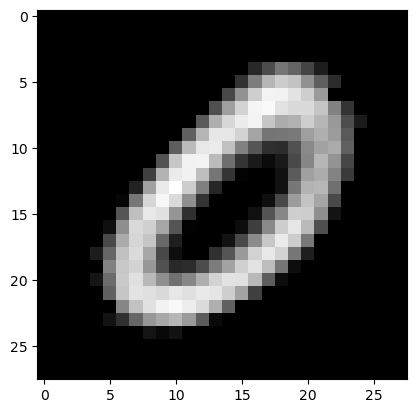

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [29]:
model.img_gen(key, params, n_classes=num_classes, img_class=0, h=1, w=1)

In [30]:
test_dataset = MNIST('data', train = False, transform=T.ToTensor(), download=True)
# test_dataset.data = test_dataset.data / 255
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [31]:
total_loss, total_mse, total_kl, loss_distrib = model.evaluate(key, params, n_classes=num_classes, data_loader=test_loader, batch_size=batch_size, get_loss_distrib=True)

Loss totale moyenne = 17.05521583557129
MSE totale moyenne = 14.486470222473145
kl totale moyenne = 2.5687263011932373


In [47]:
class_of_ref = 0
quantile = 0.99 # by default, should be fine-tuned with cross validation methods


img = prepare_test_set(test_loader.dataset, class_of_ref, mixed_classes=True)
    
thresh = jnp.quantile(jnp.asarray(loss_distrib), quantile)
anomalies = model.det_anom(key, params, img, n_classes=num_classes, tested_class=class_of_ref, threshold=thresh)

Image 0 | loss = 46.95705795288086 ~ mse = 45.30791091918945. kl = 1.6491472721099854
Image 1 | loss = 40.846343994140625 ~ mse = 38.77825927734375. kl = 2.0680840015411377
Image 2 | loss = 43.7667121887207 ~ mse = 42.12091827392578. kl = 1.6457927227020264
Image 3 | loss = 16.453550338745117 ~ mse = 13.86862564086914. kl = 2.5849242210388184
Image 4 | loss = 51.78437805175781 ~ mse = 49.35668182373047. kl = 2.427696704864502
Image 5 | loss = 46.9950065612793 ~ mse = 45.57130432128906. kl = 1.4237020015716553
Image 6 | loss = 49.98847198486328 ~ mse = 48.432159423828125. kl = 1.5563135147094727
Image 7 | loss = 40.84624481201172 ~ mse = 37.68585968017578. kl = 3.160384178161621
Image 8 | loss = 47.14474105834961 ~ mse = 45.68415069580078. kl = 1.4605903625488281
Image 9 | loss = 45.35223388671875 ~ mse = 42.513954162597656. kl = 2.838280200958252
Image 10 | loss = 14.206409454345703 ~ mse = 11.102203369140625. kl = 3.1042065620422363
Image 11 | loss = 40.96507263183594 ~ mse = 38.28424

KeyboardInterrupt: 

In [44]:
print(jnp.sum(anomalies["estAnomalie"] == False))
print(jnp.sum(jnp.asarray(anomalies["estAnomalie"]) == True))

868
9132


In [49]:
y_true = get__y_true(test_loader.dataset, class_of_ref=class_of_ref)

In [50]:
# MNIST dataset

print(classification_report(y_true, anomalies["estAnomalie"]))

              precision    recall  f1-score   support

       False       0.88      0.78      0.83       980
        True       0.98      0.99      0.98      9020

    accuracy                           0.97     10000
   macro avg       0.93      0.89      0.91     10000
weighted avg       0.97      0.97      0.97     10000



In [142]:
# FashionMNIST dataset
from sklearn.metrics import classification_report

print(classification_report(y_true, anomalies["estAnomalie"]))

              precision    recall  f1-score   support

       False       0.29      0.84      0.43      1000
        True       0.98      0.77      0.86      9000

    accuracy                           0.78     10000
   macro avg       0.63      0.81      0.64     10000
weighted avg       0.91      0.78      0.82     10000

